<a href="https://colab.research.google.com/github/Kazuyasus/Econometrics/blob/main/6th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_hc1
from statsmodels.formula.api import ols


# シミュレーションの設定
n_obs1 = 100
n_obs2 = 50
n_rep = 10000

# Monte Carlo シミュレーションの結果を保存するデータフレーム
result1 = pd.DataFrame({"unbiased": np.nan, "biased": np.nan, "corr": np.nan}, index=range(n_rep))

# シミュレーションの実行
for i in range(n_rep):
    educ = 14 + np.random.normal(0, 2, n_obs1)
    abil = educ * 7 + 2 + np.random.normal(0, 8, n_obs1)
    wage = 50 + educ * 2 + abil * 0.8 + np.random.normal(0, 20, n_obs1)

    unbiased_model = smf.ols("wage ~ educ + abil", data=pd.DataFrame({"wage": wage, "educ": educ, "abil": abil})).fit()
    biased_model = smf.ols("wage ~ educ", data=pd.DataFrame({"wage": wage, "educ": educ})).fit()

    result1.loc[i, "unbiased"] = unbiased_model.params["educ"]
    result1.loc[i, "biased"] = biased_model.params["educ"]
    result1.loc[i, "corr"] = np.corrcoef(educ, abil)[0, 1]


# 結果の統計量を表示
print(result1.describe())


           unbiased        biased          corr
count  10000.000000  10000.000000  10000.000000
mean       2.003614      7.599375      0.866775
std        2.066973      1.077099      0.025443
min       -7.321862      3.514626      0.742794
25%        0.627322      6.887093      0.851023
50%        2.038613      7.594043      0.869056
75%        3.403152      8.325954      0.884946
max       11.556596     11.715142      0.939464


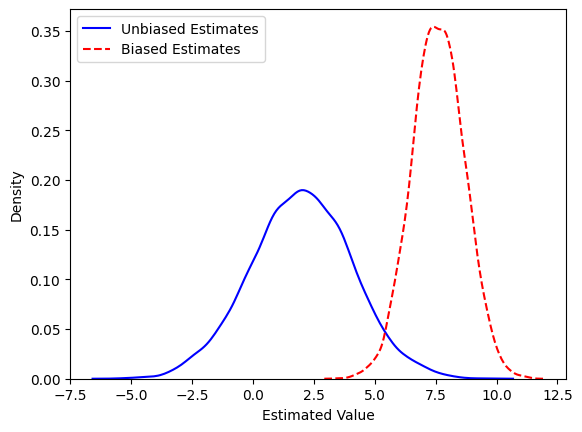

In [ ]:
# 分布の可視化
sns.kdeplot(result1["unbiased"], color="blue", linestyle="solid", label="Unbiased Estimates")
sns.kdeplot(result1["biased"], color="red", linestyle="dashed", label="Biased Estimates")
plt.xlabel("Estimated Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:

# GitHubのdataを利用
url = "https://raw.githubusercontent.com/Kazuyasus/Econometrics/main/criminal.csv"

# CSVを読み込む
crimes=pd.read_csv(url)


# 最小二乗法 (OLS)
result_ols = smf.ols("crime ~ unemp", data=crimes).fit()
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  crime   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 1.853e+04
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        02:15:37   Log-Likelihood:                -14478.
No. Observations:                1750   AIC:                         2.896e+04
Df Residuals:                    1748   BIC:                         2.897e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -111.7537     24.026     -4.651      0.0

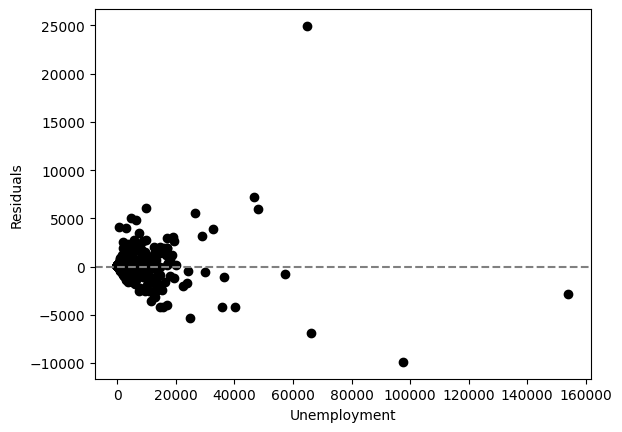

In [ ]:
# 残差プロット
plt.scatter(crimes["unemp"], result_ols.resid, color="black", marker="o")
plt.xlabel("Unemployment")
plt.ylabel("Residuals")
plt.axhline(y=0, color="gray", linestyle="dashed")
plt.show()

In [ ]:
# Breusch-Pagan検定（均一分散性の検定）
bp_test = het_breuschpagan(result_ols.resid, result_ols.model.exog)
print(f"Breusch-Pagan test: p-value = {bp_test[1]}")

Breusch-Pagan test: p-value = 1.6381279920507202e-55


In [ ]:
#不均一分散を考慮したRobust Standard Error
ols_robust= smf.ols("crime ~ unemp", data=crimes). fit(cov_type = "HC1")
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  crime   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     290.1
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           2.61e-60
Time:                        02:15:44   Log-Likelihood:                -14478.
No. Observations:                1750   AIC:                         2.896e+04
Df Residuals:                    1748   BIC:                         2.897e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -111.7537     47.467     -2.354      0.0

In [ ]:
# 重み付き最小二乗法 (WLS)
result_wls = smf.wls("crime ~ unemp", data=crimes, weights=crimes["pop"]).fit()
print(result_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  crime   R-squared:                       0.913
Model:                            WLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.845e+04
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        02:15:46   Log-Likelihood:                -17981.
No. Observations:                1750   AIC:                         3.597e+04
Df Residuals:                    1748   BIC:                         3.598e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    278.9745    116.271      2.399      0.0

In [ ]:
# 多重共線性の確認（VIF）
X = crimes[["unemp", "pop"]]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable        VIF
0    const   1.175562
1    unemp  11.087283
2      pop  11.087283


In [ ]:
#推計結果を一つにまとめる
!pip install stargazer
#pip install stargazer
from stargazer.stargazer import Stargazer
model1_stargazer = Stargazer([result_ols, result_wls])
model1_stargazer